# Isotope Detection

Isotopologues, or molecules that differ only in their isotopic composition, are common in mass spectrometry analyses.
In many analysis workflows, isotopologues are used to downselect the total feature list to include only the most abundant feature, as well as to glean ion charge state and provide further evidence for identification by way of a detected isotopic signature. 

Isotopes are detected by enumerating m/z offsets corresponding to probable isotopic distance.
Isotopic distance can be represented as the isotope mass difference (Δ*m/z*) times the number of isotopic substitutions (N), divided by the formal charge (z).
To detect C13 isotopologues for singly charged species, we specify an *m/z* delta of 1.003355 Da, a maximum number of isotopic substitutions of 5, and a maximum charge of 1.
The search is initially constrained by rough a *m/z* tolerance from the expected *m/z* delta, as well as drift time and retention time tolerances as isotopologues have similar drift and retention times.
Finally, a maximum *m/z* error of 50 ppm is used for finer-tuned downselection from the expected isotopic signature.

As isotope detection is evaluted for each pair of features, partitioning is recommended as to limit comparisons distant in *m/z*.
Unlike partitioning in other applications, however, we must select a large overlap to ensure each partition contains the range of values necessary for a complete isotopologue search.
As such, if the search includes up to 5 substitions for a singly-charged species, overlap should be ~5.1.

In [1]:
import deimos
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load data
ms1_peaks = deimos.load('example_data_peaks.h5', key='ms1',
                        columns=['mz', 'drift_time', 'retention_time', 'intensity'])
ms1_peaks = deimos.threshold(ms1_peaks, threshold=1000)

In [3]:
# Partition the data
partitions = deimos.partition(ms1_peaks, size=1000, overlap=5.1)

# Map isotope detection over partitions
isotopes = partitions.map(deimos.isotopes.detect,
                          dims=['mz', 'drift_time', 'retention_time'],
                          tol=[0.1, 0.7, 0.15],
                          delta=1.003355,
                          max_isotopes=5,
                          max_charge=1,
                          max_error=50E-6)

The detection process makes no assumptions as to expected intensity relationship, nor does it downselect by number of isotopologues in a given signature. A good first screening is to only consider those isotopic signatures with at least 3 members.

In [4]:
isotopes.loc[isotopes['n'] >= 3, :].sort_values(by='intensity', ascending=False).head(5)

,mz,charge,idx,intensity,multiple,dx,mz_iso,intensity_iso,idx_iso,error,decay,n
213,496.337463,1.0,2942.0,47870.839844,"[1.0, 2.0, 3.0]","[1.003355, 2.00671, 3.010065]","[497.33770751953125, 498.3426818847656, 499.34...","[1300.0, 6340.09912109375, 1322.932373046875]","[3008.0, 2979.0, 2953.0]","[6.267629595844456e-06, 3.00500012727506e-06, ...","[0.027156406786327303, 0.13244177753696776, 0....",3
382,758.570374,1.0,5.0,26914.226562,"[1.0, 2.0, 3.0, 4.0]","[1.003355, 2.00671, 3.010065, 4.01342]","[759.572265625, 760.5823364257812, 761.5858154...","[16724.888671875, 15582.22265625, 6832.1909179...","[3088.0, 23.0, 104.0, 114.0, 870.0, 1108.0]","[1.9285094795258275e-06, 6.9247242026076295e-0...","[0.6214144267915929, 0.5789585898025005, 0.253...",4
383,782.567932,1.0,3029.0,18975.044922,"[1.0, 3.0, 5.0]","[1.003355, 3.010065, 5.016775]","[783.5687866210938, 785.5840454101562, 787.600...","[10170.6875, 6370.03369140625, 8672.080078125]","[3043.0, 3056.0, 3091.0]","[3.1952597465853074e-06, 7.728761940891445e-06...","[0.5360033423833915, 0.33570585564531047, 0.45...",3
15,191.088333,1.0,3300.0,18423.130859,"[2.0, 3.0, 4.0]","[2.00671, 3.010065, 4.01342]","[193.10104370117188, 194.1031494140625, 195.10...","[2172.52197265625, 5482.02099609375, 1463.0]","[3310.0, 3352.0, 3309.0]","[3.140208086374334e-05, 2.486433421583127e-05,...","[0.11792360317251485, 0.2975618551449472, 0.07...",3
220,520.33606,1.0,14.0,17845.337891,"[1.0, 2.0, 3.0]","[1.003355, 2.00671, 3.010065]","[521.339111328125, 521.3395385742188, 522.3541...","[6994.01416015625, 5568.76220703125, 9997.2265...","[100.0, 146.0, 48.0, 52.0, 368.0]","[5.827814196663802e-07, 2.3831503500334787e-07...","[0.39192388527597094, 0.3120569776354184, 0.56...",3


Now we'll plot a high-intensity feature with 5 member isopologues.

In [5]:
ms1 = deimos.load('example_data.h5', key='ms1')

In [6]:
feature = deimos.slice(ms1, by=['mz', 'drift_time', 'retention_time'],
                       low=[758.570374 - 0.5, 34.4, 0.75],
                       high=[758.570374 + 5.116775, 36.5, 2])

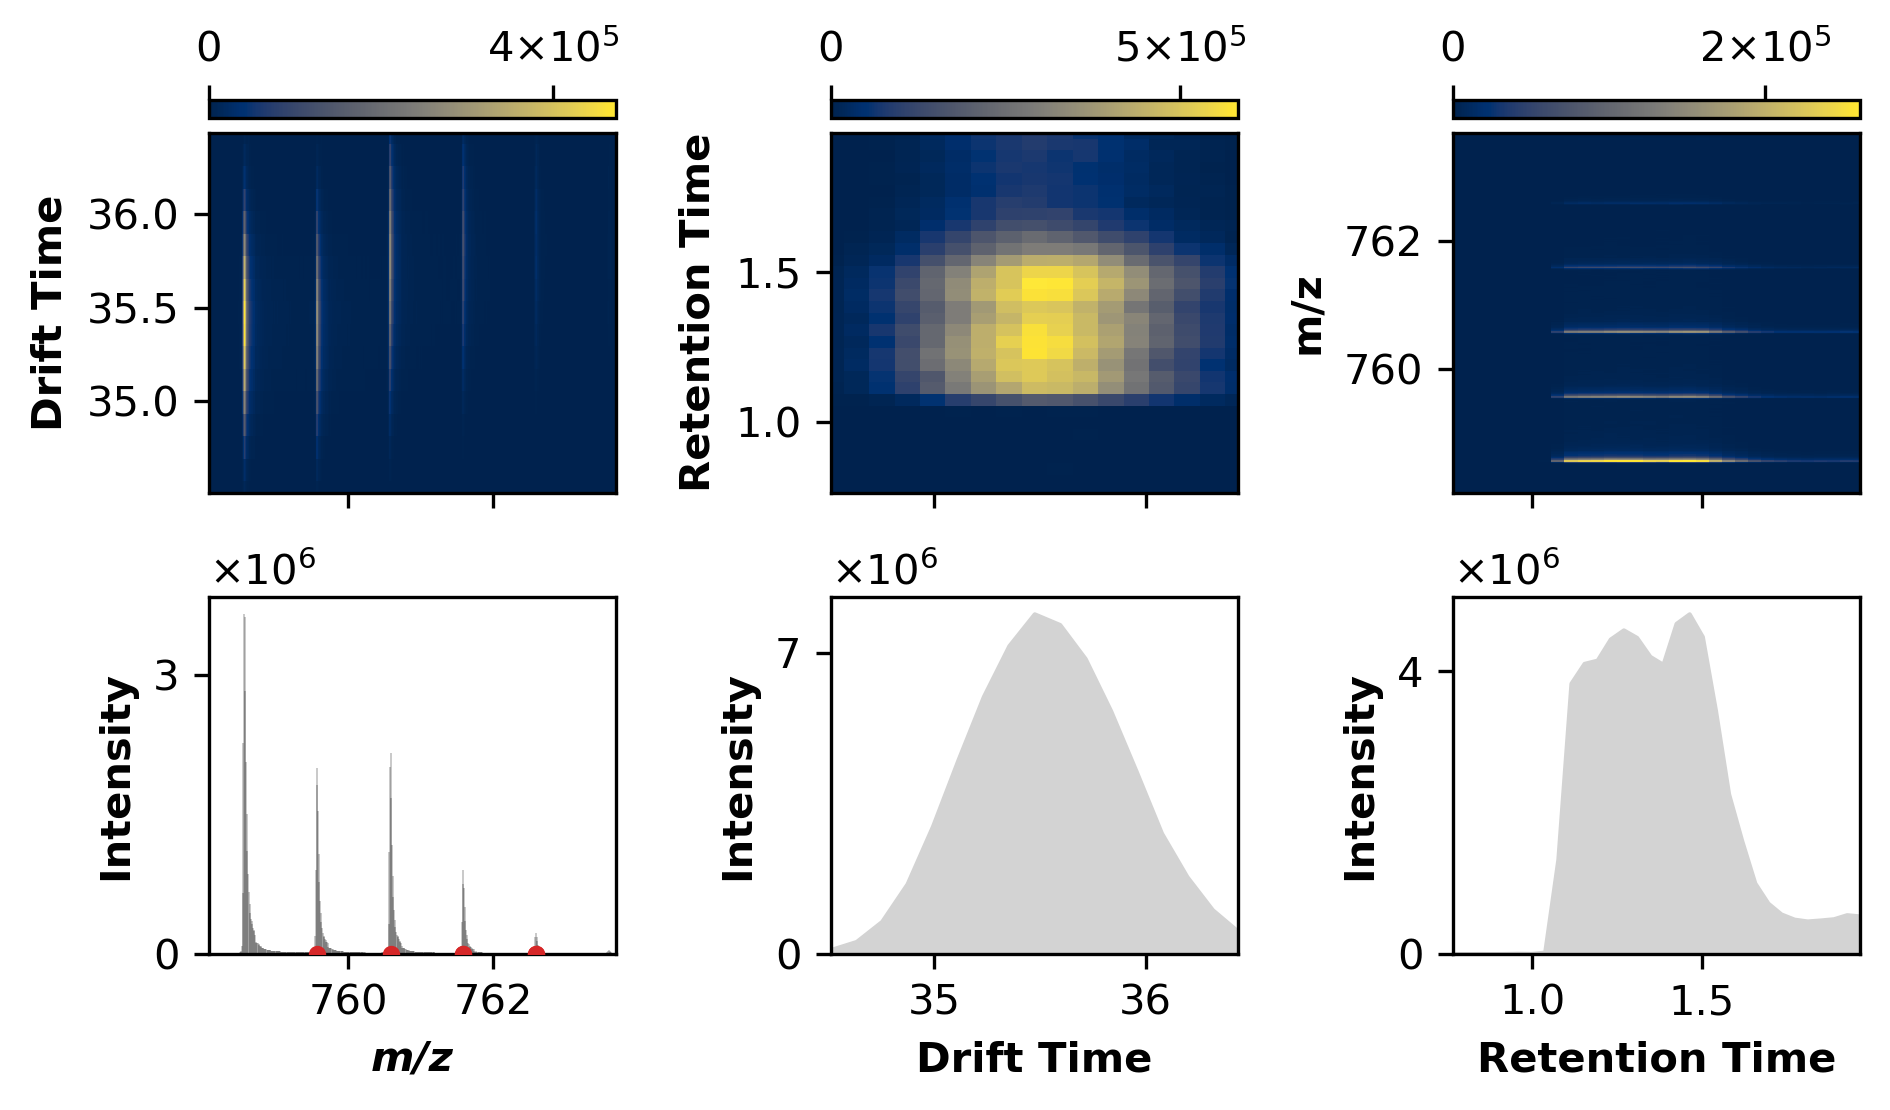

In [7]:
ax = deimos.plot.multipanel(feature, dpi=300)

for i in isotopes.loc[382, 'mz_iso']:
    ax['mz'].scatter(i, 0, s=10, color='C3', zorder=5)

plt.tight_layout()
plt.show()